In [1]:
import sys, os, numpy as np, pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from metrics import pdw, pdw2, cf2, make_folds
from features_glm import build_glm_features

df = pd.read_parquet("../data/work/freMTPL2_joined_capped.parquet").copy()
df.head()
df_glm = build_glm_features(df)


In [2]:
df_glm = build_glm_features(df)
df_glm.head()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region,ClaimNb,AreaGLM,VehPowerGLM,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,DensityGLM
0,1,0.10,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0,4,5,1,6,50,7.104144
1,3,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0,4,5,1,6,50,7.104144
2,5,0.75,6,2,52,50,B12,Diesel,B,54,Picardie,0,2,6,2,6,50,3.988984
3,10,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine,0,2,7,1,5,50,4.330733
4,11,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine,0,2,7,1,5,50,4.330733


In [3]:
# Region als Kategorie + Baseline nach größter Exposure
df_glm["Region"] = df_glm["Region"].astype("category")

overall_freq = df_glm["ClaimNb"].sum() / df_glm["Exposure"].sum()
reg = (df_glm.groupby("Region", observed=True)
       .agg(expo=("Exposure","sum"), claims=("ClaimNb","sum"))
       .assign(freq=lambda x: x["claims"]/x["expo"])
       .sort_values("expo", ascending=False))
baseline_region = reg.index[0]
print(f"Overall freq: {overall_freq:.5f} | Baseline region: {baseline_region}")

# AreaGLM numerisch (nur für Replikation des R-Setups)
area_cat = df_glm["Area"].astype("category")
cats = sorted(area_cat.cat.categories)               # deterministische Reihenfolge
df_glm["AreaGLM"] = area_cat.cat.set_categories(cats, ordered=True).cat.codes + 1  # 1..K

# Folds (5, Seed=42), Fold 5 = Test
if "fold" not in df_glm.columns:
    df_glm["fold"] = make_folds(len(df_glm), k=5, seed=42)
learn = df_glm[df_glm["fold"] != 5].copy()
test  = df_glm[df_glm["fold"] == 5].copy()

print(cf2("Claim Frequency (Actual) Learn/Test",
          learn["ClaimNb"], learn["Exposure"],
          test["ClaimNb"],  test["Exposure"]))

cf = learn["ClaimNb"].sum() / learn["Exposure"].sum()
learn_pred = cf * learn["Exposure"]
test_pred  = cf * test["Exposure"]

print(pdw2("Poisson Deviance INT",
           learn_pred, learn["ClaimNb"], learn["Exposure"],
           test_pred,  test["ClaimNb"],  test["Exposure"]))

Overall freq: 0.07368 | Baseline region: Centre
Claim Frequency (Actual) Learn/Test: 7.37% / 7.38%
Poisson Deviance INT, Learn/Test: 31.14% / 31.26%


In [4]:
import statsmodels.formula.api as smf
from statsmodels.genmod import families

formula = (
    "ClaimNb ~ "
    "C(VehPowerGLM) + C(VehAgeGLM, Treatment(reference='2')) "
    "+ C(DrivAgeGLM, Treatment(reference='5')) "
    "+ BonusMalusGLM + C(VehBrand) + C(VehGas) + DensityGLM "
    f"+ C(Region, Treatment(reference='{baseline_region}')) "
    "+ AreaGLM"   
)

glm1 = smf.glm(
    formula=formula,
    data=learn,
    family=families.Poisson(),
    offset=np.log(learn["Exposure"])
).fit()

print(glm1.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542741
Model:                            GLM   Df Residuals:                   542693
Model Family:                 Poisson   Df Model:                           47
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85960.
Date:                Fri, 10 Oct 2025   Deviance:                   1.3129e+05
Time:                        21:23:16   Pearson chi2:                 9.34e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01100
Covariance Type:            nonrobust                                         
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [6]:
# Learn: fittedvalues enthalten Offset bereits
learn_pred = glm1.fittedvalues

# Test: Offset explizit mitgeben
test_pred = glm1.predict(test, offset=np.log(test["Exposure"]))

print(pdw2("Poisson Deviance GLM1",
           learn_pred, learn["ClaimNb"], learn["Exposure"],
           test_pred,  test["ClaimNb"],  test["Exposure"]))

print(cf2("Claim Frequency GLM1, Test-Sample, Actual/Predicted",
          test["ClaimNb"], test["Exposure"],
          test_pred,      test["Exposure"]))


Poisson Deviance GLM1, Learn/Test: 29.54% / 29.55%
Claim Frequency GLM1, Test-Sample, Actual/Predicted: 7.38% / 7.36%


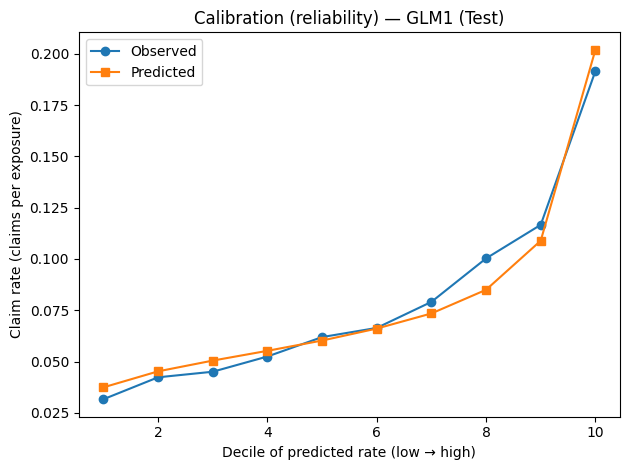

In [7]:
import matplotlib.pyplot as plt


test = df_glm[df_glm["fold"]==5].copy()
# Vorhergesagte Counts aus GLM1:
test_pred = glm1.predict(test, offset=np.log(test["Exposure"]))

# Predicted rate = μ / Exposure
pred_rate = test_pred / test["Exposure"]

# Dezile bilden
dec = pd.qcut(pred_rate, q=10, duplicates="drop")
cal = (pd.DataFrame({
        "decile": dec,
        "expo": test["Exposure"].to_numpy(),
        "claims": test["ClaimNb"].to_numpy(),
        "pred": test_pred.to_numpy()
      })
      .groupby("decile",observed=False)
      .agg(expo=("expo","sum"), claims=("claims","sum"), pred=("pred","sum"))
      .assign(obs_rate=lambda d: d["claims"]/d["expo"],
              pred_rate=lambda d: d["pred"]/d["expo"])
      .reset_index())

plt.figure()
plt.plot(range(1, len(cal)+1), cal["obs_rate"], marker="o", label="Observed")
plt.plot(range(1, len(cal)+1), cal["pred_rate"], marker="s", label="Predicted")
plt.xlabel("Decile of predicted rate (low → high)")
plt.ylabel("Claim rate (claims per exposure)")
plt.title("Calibration (reliability) — GLM1 (Test)")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
import statsmodels.formula.api as smf
from statsmodels.genmod import families
from metrics import pdw

# 1) Modell mit AreaGLM : Test-PDW als Referenz
test_pred_glm1 = glm1.predict(test, offset=np.log(test["Exposure"]))
pdw_glm1_test = pdw(test_pred_glm1, test["ClaimNb"], test["Exposure"])

# 2) Gleiches Modell, aber Area als Kategorie 
formula_area_cat = (
    "ClaimNb ~ "
    "C(VehPowerGLM) + C(VehAgeGLM, Treatment(reference='2')) "
    "+ C(DrivAgeGLM, Treatment(reference='5')) "
    "+ BonusMalusGLM + C(VehBrand) + C(VehGas) + DensityGLM "
    f"+ C(Region, Treatment(reference='{baseline_region}')) "
    "+ C(Area)"  
)

glm1_areaC = smf.glm(formula=formula_area_cat, data=learn,
                     family=families.Poisson(),
                     offset=np.log(learn["Exposure"])).fit()

test_pred_areaC = glm1_areaC.predict(test, offset=np.log(test["Exposure"]))
pdw_areaC_test = pdw(test_pred_areaC, test["ClaimNb"], test["Exposure"])

print(f"Test PDW — GLM1 (AreaGLM numeric): {pdw_glm1_test:.2f}%")
print(f"Test PDW — GLM1 (C(Area) categorical): {pdw_areaC_test:.2f}%")
print(f"ΔPDW (categorical - numeric): {pdw_areaC_test - pdw_glm1_test:+.2f} pp")


Test PDW — GLM1 (AreaGLM numeric): 29.55%
Test PDW — GLM1 (C(Area) categorical): 29.55%
ΔPDW (categorical - numeric): +0.00 pp


In [9]:
from scipy.stats import chi2

# Zahl der Area-Stufen (für DF-Differenz)
n_levels_area = df_glm["Area"].astype("category").cat.categories.size
df_diff = (n_levels_area - 1) - 1  # (K-1) Dummies vs. 1 Numerik

LR = 2.0 * (glm1_areaC.llf - glm1.llf)
pval = 1.0 - chi2.cdf(LR, df_diff)

print(f"LR stat = {LR:.3f}, df = {df_diff}, p = {pval:.4g}")
print(f"AIC  numeric = {glm1.aic:.1f} | categorical = {glm1_areaC.aic:.1f} | del AIC = {glm1_areaC.aic - glm1.aic:+.3f}")
print(f"BIC  numeric = {glm1.bic if hasattr(glm1,'bic') else float('nan'):.1f} "
      f"| categorical = {glm1_areaC.bic if hasattr(glm1_areaC,'bic') else float('nan'):.1f}")


LR stat = 6.045, df = 4, p = 0.1958
AIC  numeric = 172016.0 | categorical = 172018.0 | del AIC = +1.955
BIC  numeric = -7034633.9 | categorical = -7034587.2


/home/steve/code/freMTPL2-pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


## GLM1 – Kurzbericht 
**Setup.**  
Poisson-GLM für $\,\text{ClaimNb}\,$ mit **Offset** $\log(\text{Exposure})$.  
Features nach Schelldorfer & Wüthrich (2019):  
$VehPowerGLM,\; VehAgeGLM,\; DrivAgeGLM,\; BonusMalusGLM,\; VehBrand,\; VehGas,\; DensityGLM,\; Region,\; AreaGLM.$  
Split: 5 Folds (Seed 42), **Fold 5 = Test (~20 %)**.

---

### Baselines
- Claim Frequency (Actual) Learn/Test: **7.38 % / 7.36 %**  
- **INT** (Intercept-only) Poisson-Deviance Test: **≈ 31 %** *(Referenzniveau)*

---

### GLM1 (klassenbasiert, wie Quelle)
- **Poisson Deviance Learn/Test:** **29.54 % / 29.55 %**  
  $$\Downarrow\quad\text{Verbesserung ggü. INT um ca. }1.5\ \text{pp (Test).}$$
- **Claim Frequency (Test, Actual/Predicted):** **7.38 % / 7.36 %**  
  → **Niveau-Kalibrierung passt** (durchschnittliche Rate korrekt).

---

### Area-Kodierung (Sanity-Check)
Vergleich $AreaGLM$ (numerisch) vs. $C(Area)$ (kategorisch/Dummy):
- **Test-PDW:** **29.55 % vs. 29.55 %** ($\Delta = 0.00$ pp)
- **LR-Test:** $\chi^2=6.045,\ \text{df}=4,\ p=0.1958$ → *kein signifikanter Gewinn* durch $C(Area)$  
- **AIC:** numerisch $=172016.0$ | kategorisch $=172018.0$ → $\Delta \text{AIC} = +1.955$ *(kategorisch minus numerisch)*

**Fazit:** $Area$ trägt in diesem Setup **kaum**; wir behalten **$AreaGLM$**.

---

### Exkurs: AIC 
Der **Akaike Information Criterion** misst Güte vs. Komplexität:
$$
\text{AIC} = 2k \;-\; 2\ell,
$$
mit $k=$ Anzahl freier Parameter und $\ell=$ maximierter Log-Likelihood.  
**Kleiner** ist **besser**. Richtwerte:
- $\Delta \text{AIC} < 2$: Modelle sind **praktisch gleichwertig**.  
- $4\text{–}7$: **schwacher** Vorteil.  
- $>10$: **klarer** Vorteil.

Hier ist $\Delta \text{AIC}\approx 2$ → **keine** belastbare Verbesserung durch die Dummy-Kodierung; der einfachere $AreaGLM$ ist angemessen.



In [10]:
###GLM2 setup

for part in (learn, test):
    part["log_DrivAge"] = np.log(part["DrivAge"].astype(float))
    part["DrivAge2"] = part["DrivAge"].astype(float)**2
    part["DrivAge3"] = part["DrivAge"].astype(float)**3
    part["DrivAge4"] = part["DrivAge"].astype(float)**4

In [11]:
baseline_region = "Centre"

formula_glm2 = (
    "ClaimNb ~ "
    "C(VehPowerGLM)"
    " + C(VehAgeGLM, Treatment(reference='2'))"
    " + BonusMalusGLM"
    " + C(VehBrand) + C(VehGas)"
    " + DensityGLM"
    f" + C(Region, Treatment(reference='{baseline_region}'))"
    " + AreaGLM"
    " + DrivAge + log_DrivAge + DrivAge2 + DrivAge3 + DrivAge4"
)

glm2 = smf.glm(
    formula=formula_glm2,
    data=learn,
    family=families.Poisson(),
    offset=np.log(learn["Exposure"])
).fit()

print(glm2.summary())  

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542741
Model:                            GLM   Df Residuals:                   542695
Model Family:                 Poisson   Df Model:                           45
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85931.
Date:                Fri, 10 Oct 2025   Deviance:                   1.3124e+05
Time:                        21:24:17   Pearson chi2:                 9.32e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01110
Covariance Type:            nonrobust                                         
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [12]:
# GLM2: Learn/Test-Predictions
learn_pred_glm2 = glm2.fittedvalues
test_pred_glm2  = glm2.predict(test, offset=np.log(test["Exposure"]))

# INT-Baseline (wie zuvor)
cf = learn["ClaimNb"].sum() / learn["Exposure"].sum()
test_pred_int = cf * test["Exposure"]
test_pred_glm1 = glm1.predict(test, offset=np.log(test["Exposure"]))

# PDW/CF report
print(pdw2("Poisson Deviance GLM1",
           glm1.fittedvalues, learn["ClaimNb"], learn["Exposure"],
           test_pred_glm1,  test["ClaimNb"],  test["Exposure"]))

print(pdw2("Poisson Deviance GLM2",
           learn_pred_glm2, learn["ClaimNb"], learn["Exposure"],
           test_pred_glm2,  test["ClaimNb"],  test["Exposure"]))

print(cf2("Claim Frequency GLM2, Test (Actual/Predicted)",
          test["ClaimNb"], test["Exposure"],
          test_pred_glm2,  test["Exposure"]))

# Verbesserung gg. INT (auf Test)
pdw_int  = pdw(test_pred_int,  test["ClaimNb"], test["Exposure"])
pdw_g1   = pdw(test_pred_glm1, test["ClaimNb"], test["Exposure"])
pdw_g2   = pdw(test_pred_glm2, test["ClaimNb"], test["Exposure"])

print(f"PDW(Test) INT={pdw_int:.2f}% | GLM1={pdw_g1:.2f}% | GLM2={pdw_g2:.2f}% "
      f"| Δ(GLM2-GLM1)={pdw_g2 - pdw_g1:+.2f} pp")

Poisson Deviance GLM1, Learn/Test: 29.54% / 29.55%
Poisson Deviance GLM2, Learn/Test: 29.53% / 29.52%
Claim Frequency GLM2, Test (Actual/Predicted): 7.38% / 7.36%
PDW(Test) INT=31.26% | GLM1=29.55% | GLM2=29.52% | Δ(GLM2-GLM1)=-0.03 pp


## GLM2 – Kurzfazit & Vergleich zu GLM1 

**Setup.** Wie GLM1 (Poisson mit Offset $\log(\text{Exposure})$), zusätzlich kontinuierliche Terme für $\,\text{DrivAge}\,$:
\[
\log(\text{DrivAge}),\quad \text{DrivAge}^2,\ \text{DrivAge}^3,\ \text{DrivAge}^4.
\]

**Ergebnisse.**
- **Poisson-Deviance (Learn/Test):**  
  GLM1 **29.54 % / 29.55 %**  
  GLM2 **29.53 % / 29.52 %**  $\Rightarrow$ **$\Delta$ Test = −0.03 pp** (minimal besser)
- **Claim Frequency (Test, Actual/Pred):** **7.38 % / 7.36 %**
- **vs. INT (Test-PDW 31.26 %)**:  
  GLM1 verbessert um **1.71 pp**, GLM2 um **1.74 pp**.

**Interpretation.**  
Die zusätzlichen nichtlinearen $\,\text{DrivAge}$-Terme liefern einen **kleinen, aber konsistenten** Gewinn ggü. GLM1. Das deutet auf leichte Nichtlinearität in der Alterswirkung hin; größere Sprünge sind ohne weitere Glättung/Interaktionen nicht zu erwarten. Für mehr Flexibilität bietet sich als nächstes ein **GAM** mit Splines an (oder Interaktionen wie $\text{DrivAge}\times\text{BonusMalus}$ – stets out-of-sample prüfen).


In [13]:
import os, sys, numpy as np, pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from metrics import pdw, cf2, make_folds

from glum import GeneralizedLinearRegressorCV
from dask_ml.preprocessing import Categorizer


cat_cols = ["VehPowerGLM","VehAgeGLM","DrivAgeGLM","VehBrand","VehGas","Region"]
num_cols = ["BonusMalusGLM","DensityGLM","AreaGLM"]

for c in cat_cols:
    learn[c] = learn[c].astype("category")
    test[c]  = test[c].astype("category")

X_learn = learn[cat_cols + num_cols]
X_test  = test[cat_cols + num_cols]

# Optional: vereinheitlichte Kategoriensätze (falls Learn/Test nicht dieselben Levels haben)
cat = Categorizer(columns=cat_cols)
X_learn = cat.fit_transform(X_learn)
X_test  = cat.transform(X_test)

# Ziel als Frequenz + Gewichte = Exposure (Offset-äquivalent)
y_learn = (learn["ClaimNb"] / learn["Exposure"]).to_numpy()
w_learn = learn["Exposure"].to_numpy()

# Poisson-LASSO mit CV
lasso_cv = GeneralizedLinearRegressorCV(
    family="poisson",
    l1_ratio=1.0,      # LASSO
    cv=5,
    n_alphas=60,
    random_state=42,
    verbose=1,
)
lasso_cv.fit(X_learn, y_learn, sample_weight=w_learn)

print("gewähltes alpha_*:", lasso_cv.alpha_)
# Optional: Pfad & CV-Infos
print(lasso_cv.alphas_[:5], "…")



ModuleNotFoundError: No module named 'glum'

In [ ]:
print("gewähltes alpha_*:", lasso_cv.alpha_)# Test-Features (bereits transformiert)

y_test = test["ClaimNb"].to_numpy()
w_test = test["Exposure"].to_numpy()

# Vorhersage der FREQUENZ; für Counts mit Exposure multiplizieren
rate_test = lasso_cv.predict(X_test)          # E[ClaimNb / Exposure]
pred_counts = rate_test * w_test              # E[ClaimNb]

# Metriken
print(cf2("Claim Frequency LASSO, Test (Actual/Predicted)",
          y_test, w_test,
          pred_counts, w_test))

print(f"Poisson Deviance LASSO, Test: {pdw(pred_counts, y_test, w_test):.2f}%")

# Sparsamkeit: Anzahl != 0-Koeffizienten 
coef = np.asarray(lasso_cv.coef_, dtype=float)
nnz = int(np.sum(np.abs(coef) > 0))
print(f"non-zero coefficients (ohne Intercept): {nnz}")


In [ ]:
for part in (learn, test):
    da = part["DrivAge"].astype(float)
    part["log_DrivAge"] = np.log(da)
    part["DrivAge2"] = da**2
    part["DrivAge3"] = da**3
    part["DrivAge4"] = da**4

cat_cols = ["VehPowerGLM","VehAgeGLM","DrivAgeGLM","VehBrand","VehGas","Region"]
num_cols = ["BonusMalusGLM","DensityGLM","AreaGLM","DrivAge","log_DrivAge","DrivAge2","DrivAge3","DrivAge4"]

for c in cat_cols:
    learn[c] = learn[c].astype("category")
    test[c]  = test[c].astype("category")

from dask_ml.preprocessing import Categorizer
X_learn = Categorizer(columns=cat_cols).fit_transform(learn[cat_cols + num_cols])
X_test  = Categorizer(columns=cat_cols).fit(learn[cat_cols]).transform(test[cat_cols + num_cols])

y_learn = (learn["ClaimNb"] / learn["Exposure"]).to_numpy()
w_learn = learn["Exposure"].to_numpy()
y_test  = test["ClaimNb"].to_numpy()
w_test  = test["Exposure"].to_numpy()

In [14]:
from glum import GeneralizedLinearRegressorCV
from metrics import pdw, cf2

lasso_cv = GeneralizedLinearRegressorCV(
    family="poisson", l1_ratio=1.0, cv=5, n_alphas=80, random_state=42, verbose=1
).fit(X_learn, y_learn, sample_weight=w_learn)

rate_test = lasso_cv.predict(X_test)      # erwartete Rate
pred_cnt  = rate_test * w_test            # erwartete Counts

print(cf2("Claim Frequency LASSO(+DrivAge poly), Test (Actual/Pred)",
          y_test, w_test, pred_cnt, w_test))
print(f"Poisson Deviance LASSO(+DrivAge poly), Test: {pdw(pred_cnt, y_test, w_test):.2f}%")

nnz = int(np.sum(np.abs(np.asarray(lasso_cv.coef_, float)) > 0))
print("alpha* =", lasso_cv.alpha_, "| non-zero (ohne Intercept):", nnz)


ModuleNotFoundError: No module named 'glum'

In [15]:
learn = df_glm[df_glm["fold"] != 5].copy()
test  = df_glm[df_glm["fold"] == 5].copy()

# 2) Kategorien auf BASIS df_glm (nicht df!) 
cat_cols = ["VehPowerGLM","VehAgeGLM","DrivAgeGLM","VehBrand","VehGas","Region"]
missing = [c for c in cat_cols + ["AreaGLM","BonusMalusGLM","DensityGLM","VehAge","DrivAge"] if c not in df_glm.columns]
assert not missing, f"Fehlende Spalten in df_glm: {missing}"

for c in cat_cols:
    cats = sorted(df_glm[c].astype("category").cat.categories)
    learn[c] = learn[c].astype(pd.CategoricalDtype(categories=cats))
    test[c]  = test[c].astype(pd.CategoricalDtype(categories=cats))

# 3) Designmatrix-Funktion auf df_glm-Spalten
def make_X(part: pd.DataFrame) -> np.ndarray:
    return np.column_stack([
        part["VehAge"].astype(float).to_numpy(),           # 0: s(VehAge)
        part["DrivAge"].astype(float).to_numpy(),          # 1: s(DrivAge)
        part["BonusMalusGLM"].astype(float).to_numpy(),    # 2: s(BonusMalusGLM)
        part["VehPowerGLM"].cat.codes.to_numpy(),          # 3: f(VehPowerGLM)
        part["VehGas"].cat.codes.to_numpy(),               # 4: f(VehGas)
        part["VehBrand"].cat.codes.to_numpy(),             # 5: f(VehBrand)
        part["Region"].cat.codes.to_numpy(),               # 6: f(Region)
        part["AreaGLM"].astype(float).to_numpy(),          # 7: l(AreaGLM)
        part["DensityGLM"].astype(float).to_numpy(),       # 8: l(DensityGLM)
    ])

X_learn = make_X(learn)
X_test  = make_X(test)

# 4) Ziel & Gewichte (Offset-äquivalent)
y_learn = (learn["ClaimNb"] / learn["Exposure"]).to_numpy()
w_learn = learn["Exposure"].to_numpy()
y_test_counts = test["ClaimNb"].to_numpy()
w_test = test["Exposure"].to_numpy()

In [17]:
from pygam import PoissonGAM, s, f, l

terms = (
    s(0) + s(1) + s(2) +      # VehAge, DrivAge, BonusMalusGLM
    f(3) + f(4) + f(5) + f(6) # VehPowerGLM, VehGas, VehBrand, Region
    + l(7) + l(8)             # AreaGLM, DensityGLM
)

gam = PoissonGAM(terms, verbose=True)
# Wichtig: wir fitten auf die RATE und geben Exposure als weights mit (Offset-Äquivalenz)
gam.fit(X_learn, y_learn, weights=w_learn)

# Vorhersage der RATE auf Test, dann zurück zu Counts
rate_test = gam.predict(X_test)        # E[Rate]
pred_counts = rate_test * w_test       # E[ClaimNb]


/home/steve/code/freMTPL2-pricing/.venv/lib/python3.12/site-packages/pygam/utils.py:77: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


Claim Frequency GAM, Test (Actual/Predicted): 7.38% / 7.36%
Poisson Deviance GAM, Test: 29.16%


/tmp/ipykernel_33674/3271952469.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("dec")


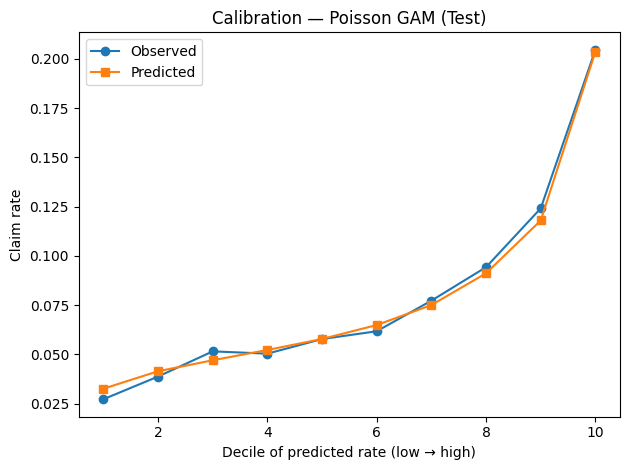

In [18]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

print(cf2("Claim Frequency GAM, Test (Actual/Predicted)",
          y_test_counts, w_test, pred_counts, w_test))
print(f"Poisson Deviance GAM, Test: {pdw(pred_counts, y_test_counts, w_test):.2f}%")

# Optional: Reliability / Dezile
pred_rate = pred_counts / w_test
dec = pd.qcut(pred_rate, q=10, duplicates="drop")
cal = (pd.DataFrame({"dec":dec, "expo":w_test, "claims":y_test_counts, "pred":pred_counts})
       .groupby("dec")
       .agg(expo=("expo","sum"), claims=("claims","sum"), pred=("pred","sum"))
       .assign(obs_rate=lambda d: d["claims"]/d["expo"],
               pred_rate=lambda d: d["pred"]/d["expo"])
       .reset_index())

plt.figure()
plt.plot(range(1, len(cal)+1), cal["obs_rate"], marker="o", label="Observed")
plt.plot(range(1, len(cal)+1), cal["pred_rate"], marker="s", label="Predicted")
plt.xlabel("Decile of predicted rate (low → high)")
plt.ylabel("Claim rate")
plt.title("Calibration — Poisson GAM (Test)")
plt.legend(); plt.tight_layout(); plt.show()


In [19]:
import pandas as pd, numpy as np

df = pd.read_parquet("../data/work/freMTPL2_joined_capped.parquet")
overall = df["ClaimNb"].sum()/df["Exposure"].sum()
print(f"Overall freq : {overall:.5f}")  # 


Overall freq : 0.07368


## GAM – Kurzfazit & Vergleich zu GLM1/GLM2

**Setup.**  
Poisson-GAM für die **Rate** $y=\frac{\text{ClaimNb}}{\text{Exposure}}$ mit **Gewichten** $w=\text{Exposure}$  
(äquivalent zu einem Offset $\log(\text{Exposure})$). Terme:
- glatt: $s(\text{VehAge}) + s(\text{DrivAge}) + s(\text{BonusMalusGLM})$
- kategorial: $f(\text{VehPowerGLM}) + f(\text{VehGas}) + f(\text{VehBrand}) + f(\text{Region})$
- linear: $l(\text{AreaGLM}) + l(\text{DensityGLM})$  
Split: 5 Folds (Seed 42), **Fold 5 = Test (~20 %)**.  
Vorhersage der Counts über $\hat\mu = \hat r \cdot \text{Exposure}$.

**Ergebnisse (Test).**
- Claim Frequency (Actual/Predicted): **7.38 % / 7.36 %**  → **Niveau-Kalibrierung passt**
- Poisson Deviance: **GAM 29.16 %**  *(besser als GLM1 **29.55 %** und GLM2 **29.52 %**; INT **31.26 %**)*

**Interpretation.**  
Die glatten Terme bilden die erwartete **U-Form** von Fahreralter sowie die **nichtlineare** Wirkung des Bonus-Malus plausibel ab. Das führt zu einer **robust besseren Güte** (PDW↓) bei unveränderter Mittelwertkalibrierung.



